In [1]:
import cartopy.crs
import cmocean.cm
import matplotlib.pyplot as plt
import numpy
import xarray
import pandas
import pathlib

In [2]:
mesh_mask = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
water_mask = mesh_mask.tmaskutil.isel(time=0)

fields = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV19-05")
salinity = fields.salinity.sel(time="2020-08-14 14:30", depth=0, method="nearest").where(water_mask)

georef = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02")

### Load locations of marine transfer facilities

##### user inputs

In [3]:
location_dir = pathlib.Path('/Users/rmueller/Data/MIDOSS/AIS')
location_file = location_dir / 'Oil_Transfer_Facilities.xlsx'

##### read in locations for marine transfer facilities

In [4]:
wa_locs = pandas.read_excel(location_file, sheet_name='Washington', 
                   usecols="B,I,J")
bc_locs = pandas.read_excel(location_file, sheet_name='British Columbia', 
                   usecols="A,B,C")

In [5]:
wa_locs

,FacilityName,DockLatNumber,DockLongNumber
0,BP Cherry Point Refinery,48.86111,-122.758
1,Shell Puget Sound Refinery,48.50945,-122.577
2,Shell Oil LP Seattle Distribution Terminal,47.58870,-122.353
3,Maxum Petroleum - Harbor Island Terminal,47.58753,-122.353
4,Tidewater Snake River Terminal,46.22312,-119.014
5,Nustar Energy Tacoma,47.26091,-122.436
6,SeaPort Sound Terminal,47.27679,-122.389
7,Tesoro Vancouver Terminal,45.63551,-122.703
8,Phillips 66 Ferndale Refinery,48.82600,-122.720
9,Phillips 66 Tacoma Terminal,47.25816,-122.434


In [6]:
bc_locs

,Name,Latitude,Longitude
0,ESSO Nanaimo Departure Bay,49.192511,-123.949857
1,Suncor Nanaimo,49.186135,-123.951153
2,Shell Chemainus Bare Point,48.928103,-123.704725
3,Chevron Cobble Hill,48.699396,-123.543780
4,Chevron Stanovan,49.290426,-123.007141
5,Barge Mooring Near Stanovan,49.290321,-122.975727
6,Shell Shellburn,49.287756,-122.964948
7,Westridge Marine Terminal,49.289402,-122.955096
8,ESSO IOCO Vancouver,49.298095,-122.884756
9,Suncor Vancouver,49.290552,-122.898765


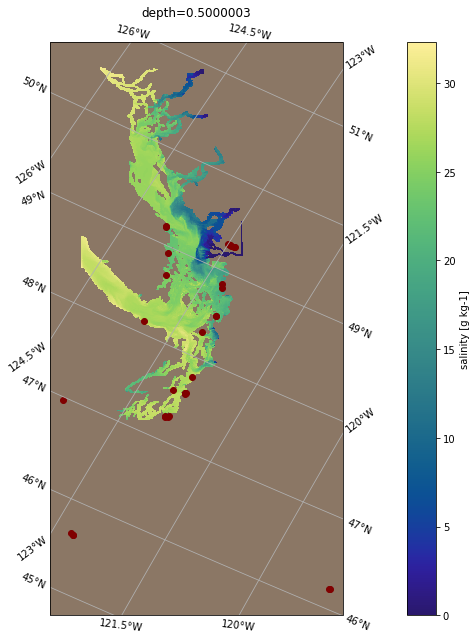

In [11]:
%matplotlib inline

rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

# Use `subplot_kw` arg to pass a dict of kwargs containing the `RotatedPole` CRS
# and the `facecolor` value to the add_subplot() call(s) that subplots() will make
fig, ax = plt.subplots(
    1, 1, figsize=(18, 9), subplot_kw={"projection": rotated_crs, "facecolor": "#8b7765"}
)

# Use the `transform` arg to tell cartopy to transform the model field
# between grid coordinates and lon/lat coordinates when it is plotted
quad_mesh = ax.pcolormesh(
    georef.longitude, georef.latitude, salinity, transform=plain_crs, cmap=cmocean.cm.haline, shading="auto"
)

# add WA locations
ax.scatter(
    wa_locs['DockLongNumber'],
    wa_locs['DockLatNumber'],
    transform=plain_crs, 
    color='maroon'
)

# add BC locations
ax.scatter(
    bc_locs['Longitude'],
    bc_locs['Latitude'],
    transform=plain_crs, 
    color='maroon'
)

# Colour bar
cbar = plt.colorbar(quad_mesh, ax=ax)
cbar.set_label(f"{salinity.attrs['long_name']} [{salinity.attrs['units']}]")
# Axes title; ax.gridlines() below labels axes tick in a way that makes
# additional axes labels unnecessary IMHO
ax.set_title(f"depth={salinity.depth.item():0.7f}")

# Don't call set_aspect() because plotting on lon/lat grid implicitly makes the aspect ratio correct

# Show grid lines
# Note that ax.grid() has no effect; ax.gridlines() is from cartopy, not matplotlib
ax.gridlines(draw_labels=True, auto_inline=False)

# cartopy doesn't seem to play nice with tight_layout() unless we call canvas.draw() first
fig.canvas.draw()
fig.tight_layout()